In [1]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from transformers import WhisperProcessor, WhisperForConditionalGeneration

audio_file = "samples/testi.wav"

# conda install -c conda-forge transformers
# conda install -c conda-forge librosa
# conda install -c conda-forge ipywidgets
# conda install -c conda-forge libsndfile
# pip install PySoundFile
# conda install -c conda-forge sentencepiece
# conda install -c conda-forge sacremoses

In [2]:
y, sr = librosa.load(audio_file, sr=16000)


print("Play the audio:")
display(Audio(y, rate=sr))

duration = librosa.get_duration(y=y, sr=sr)
print(f"\nAudio Statistics:")
print(f"Duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")

Play the audio:



Audio Statistics:
Duration: 5.12 seconds
Sample rate: 16000 Hz


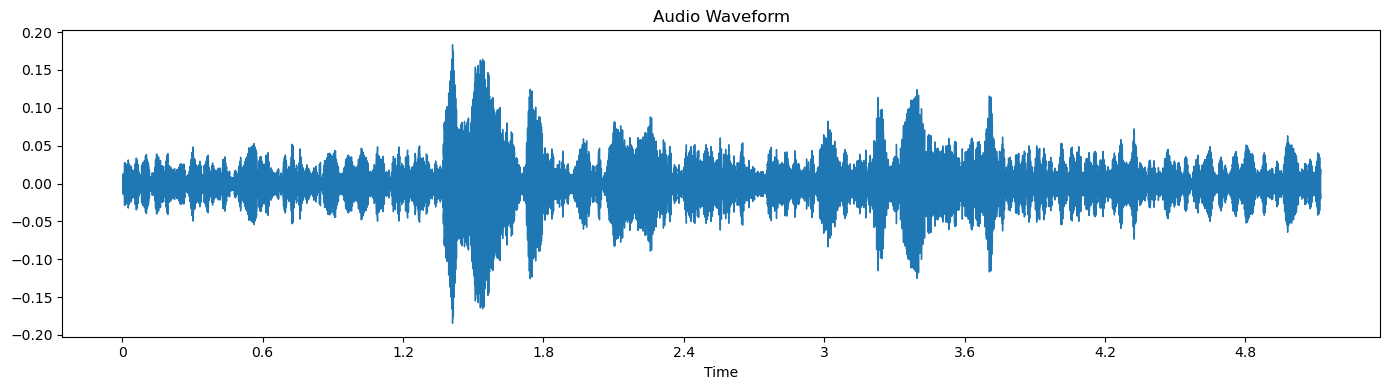

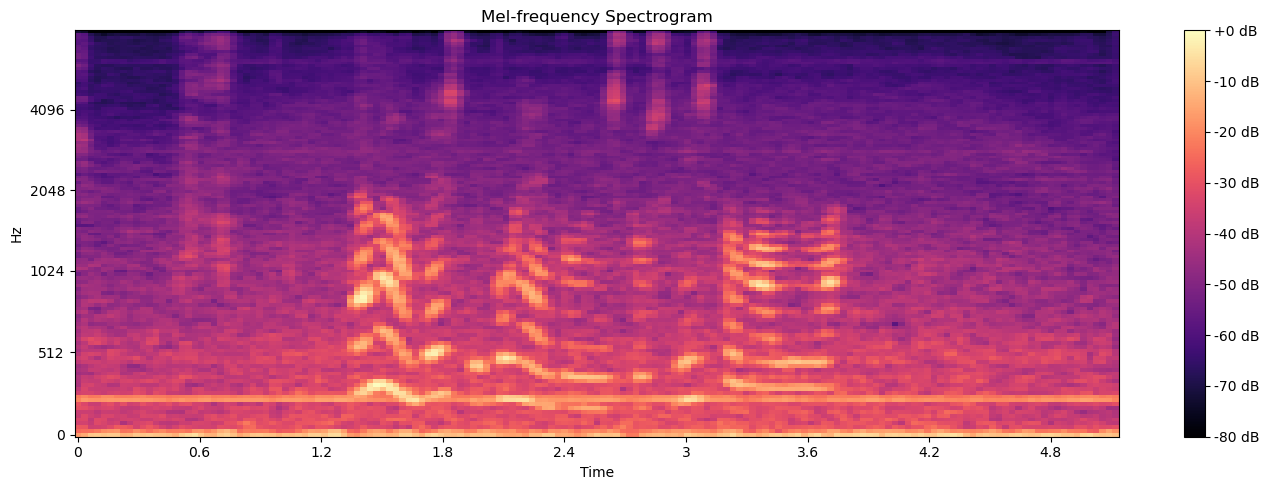

In [3]:
# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.tight_layout()
plt.show()

# Create mel spectrogram
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, y_axis='mel', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram')
plt.tight_layout()
plt.show()

In [4]:
def transcribe_with_whisper(audio_path, model_size="small"):

    # Määrittele laite
    device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "mps" if torch.backends.mps.is_available() else device
    print(f"Using device: {device}")

    # Lataa malli
    print(f"Loading Whisper {model_size} model...")
    model_name = f"openai/whisper-{model_size}"
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

    # Lataa ääni
    y, sr = librosa.load(audio_path, sr=16000)

    # Preprosessi
    input_features = processor(
        y, sampling_rate=sr, return_tensors="pt"
    ).input_features.to(device)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="fi", task="transcribe")

    # Transkriptio
    print("Generating transcription...")
    with torch.no_grad():
        generated_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)

    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription




In [6]:
test_files = {
    "Selkeä puhe": "samples/testi.wav"
}

models_to_compare = ["small", "large"]

results = {}

for model in models_to_compare:
    results[model] = {}
    for desc, filepath in test_files.items():
        print(f"\n[{model.upper()}] {desc}:")
        transcription = transcribe_with_whisper(filepath, model_size=model)
        results[model][desc] = transcription
        print(transcription)



[SMALL] Selkeä puhe:
Using device: cpu
Loading Whisper small model...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generating transcription...
 Tämä on testipuhentunnistus vispomallilla.

[LARGE] Selkeä puhe:
Using device: cpu
Loading Whisper large model...
Generating transcription...
 Tämä on testi puheen- tunnistus vistomallilla.
